# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [4]:
# for linux
# %apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# %brew install poppler tesseract libmagic

In [5]:
# %pip install -Uq "unstructured[all-docs]" pillow lxml
# %pip install -Uq chromadb tiktoken
# %pip install -Uq langchain langchain-community langchain-openai langchain-groq
# %pip install -Uq python_dotenv


In [6]:
# import os

# # keys for the services we will use

# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["GROQ_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

from dotenv import load_dotenv
load_dotenv()

True

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [7]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = output_path + 'attention.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

/Users/lkw/Desktop/SAF/AICENTER/MMRAG/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
len(chunks)

12

In [9]:
chunks[0].to_dict()

{'type': 'CompositeElement',
 'element_id': 'a43b32eb5c561ab9688edebf84b17900',
 'text': '3\n\n2023\n\n2\n\n0\n\n2\n\ng u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0\n\n7\n\n1\n\n:\n\nv\n\narXiv\n\ni\n\nX\n\nr\n\na\n\nProvided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\n\nAttention Is All You Need\n\nAshish Vaswani∗\n\nGoogle Brain\n\navaswani@google.com\n\nNoam Shazeer∗ Google Brain noam@google.com\n\nNiki Parmar∗ Google Research nikip@google.com\n\nJakob Uszkoreit∗\n\nGoogle Research usz@google.com\n\nLlion Jones∗\n\nGoogle Research llion@google.com\n\nAidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu\n\nŁukasz Kaiser∗ Google Brain lukaszkaiser@google.com\n\nIllia Polosukhin∗ ‡\n\nillia.polosukhin@gmail.com\n\nAbstract\n\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a dec

In [10]:
chunks[0].metadata.orig_elements

In [11]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [12]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [13]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '82379c69-f69f-4493-ab3f-9a6d40e715f4',
 'text': '',
 'metadata': {'coordinates': {'points': ((486.0, 261.1805555555558),
    (486.0, 614.7805555555556),
    (664.0, 614.7805555555556),
    (664.0, 261.1805555555558)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-03-06T16:29:57',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQE

### Separate extracted elements into tables, text, and images

In [14]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

print(f"Number of tables: {len(tables)}")
print(f"Number of texts: {len(texts)}")

Number of tables: 0
Number of texts: 12


In [15]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)
print(f"Number of images: {len(images)}")

Number of images: 7


#### Check what the images look like

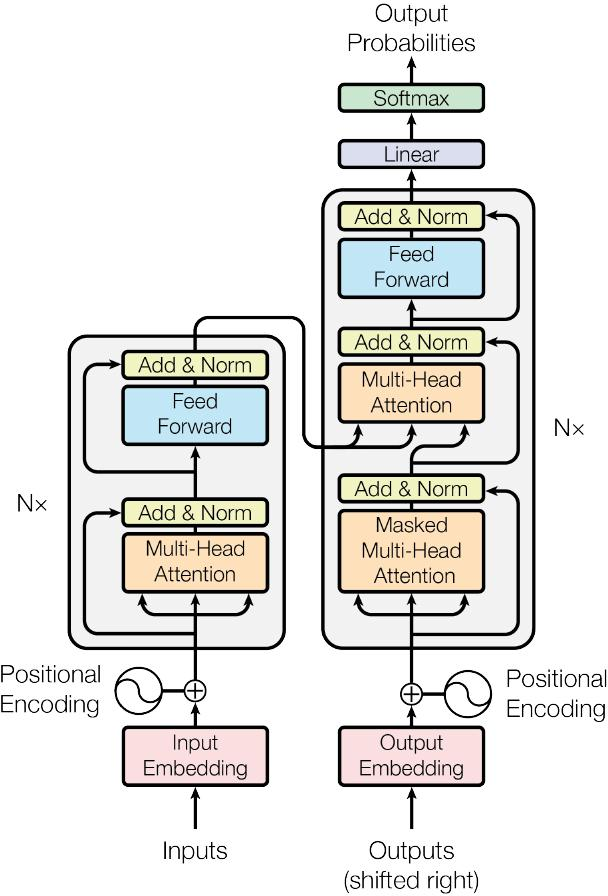

In [60]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [17]:
# # %pip install -Uq langchain-groq
# %pip install -Uq langchain-openai

In [18]:
# from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.callbacks import get_openai_callback

In [19]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
# model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant") ## QN: Is there a reason for using deferent models for answering and summarization?
# summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# KW Remake due to limit on GROQ API
model = ChatOpenAI(temperature=0.5, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()


In [20]:
# # Summarize text
# text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# # Summarize tables
# tables_html = [table.metadata.text_as_html for table in tables] # allows the model to better understand the structure of the table for additional context
# table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

# KW remake due to limit on GROQ API
# Summarize text
with get_openai_callback() as cb:
    text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})
    print(cb)

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables] # allows the model to better understand the structure of the table for additional context
with get_openai_callback() as cb:
    table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})
    print(cb)

Tokens Used: 12615
	Prompt Tokens: 10793
		Prompt Tokens Cached: 0
	Completion Tokens: 1822
		Reasoning Tokens: 0
Successful Requests: 12
Total Cost (USD): $0.43311
Tokens Used: 0
	Prompt Tokens: 0
		Prompt Tokens Cached: 0
	Completion Tokens: 0
		Reasoning Tokens: 0
Successful Requests: 0
Total Cost (USD): $0.0


In [21]:
text_summaries

['The document presents a new network architecture called the Transformer, developed by a team from Google Brain and Google Research. The Transformer is based entirely on attention mechanisms, eliminating the need for recurrent or convolutional neural networks. It outperforms existing models in machine translation tasks, achieving 28.4 BLEU on the WMT 2014 English-to-German translation task and 41.8 BLEU on the WMT 2014 English-to-French translation task. The model also shows good generalization to other tasks like English constituency parsing. It is more parallelizable and requires significantly less time to train, making it a more efficient solution.',
 'Recurrent neural networks, long short-term memory, and gated recurrent neural networks are established approaches in sequence modeling and transduction problems like language modeling and machine translation. However, their sequential nature limits parallelization within training examples. Attention mechanisms, which model dependenci

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [22]:
# %pip install -Uq langchain_openai

In [23]:
# from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()

with get_openai_callback() as cb:
    image_summaries = chain.batch(images)
    print(cb)

Tokens Used: 8411
	Prompt Tokens: 5884
		Prompt Tokens Cached: 0
	Completion Tokens: 2527
		Reasoning Tokens: 0
Successful Requests: 7
Total Cost (USD): $0.0023988


In [24]:
image_summaries

['The image illustrates an overview of the Transformer architecture, depicting its key components and flow of data.\n\n1. **Structure**: The diagram is divided into two main sections for the encoder (on the left) and decoder (on the right). Both sections contain blocks of operations that process the input embeddings and produce the output probabilities.\n\n2. **Encoder (Left Side)**:\n   - It starts with **Input Embedding**, where the input data is transformed into a vector space.\n   - **Positional Encoding** is applied to the input embeddings to retain the order of the sequence.\n   - The encoder consists of **N identical layers** (indicated by "N×"), each containing:\n     - A **Multi-Head Attention** mechanism which focuses on different parts of the input sequence.\n     - An **Add & Norm** block that captures residual connections and normalizes the output.\n     - A **Feed Forward Neural Network** which processes the embedding with non-linear transformations.\n\n3. **Decoder (Righ

In [53]:
print(images)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3PkW6yjrGpCszsO

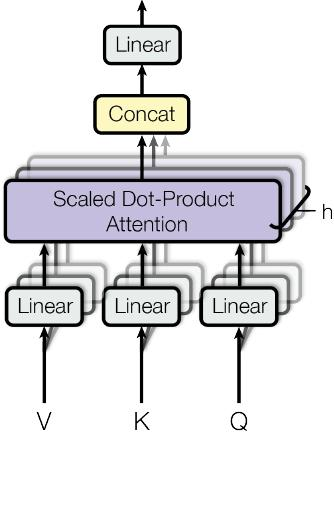

In [25]:
display_base64_image(images[2])

In [26]:
print(image_summaries[2])

The image depicts a simplified diagram of the Transformers architecture, focusing on the attention mechanism.

### Description:

1. **Components**:
   - **Input V, K, Q**: At the bottom, there are three labeled boxes: V (Values), K (Keys), and Q (Queries). Each of these components is associated with a "Linear" operation, indicating that a linear transformation is applied to these inputs.
   - **Scaled Dot-Product Attention**: Above the linear transformations, there's a prominent box labeled "Scaled Dot-Product Attention." This box is colored purple and indicates the core of the attention mechanism, where the values, keys, and queries interact.

2. **Concatenation**:
   - **Concat Operation**: Directly above the "Scaled Dot-Product Attention" box, a box labeled "Concat" signifies a concatenation operation. It suggests that the outputs from various linear transformations are combined before being processed by the attention mechanism.

3. **Arrows**:
   - Multiple arrows indicate the flow

## Load data and summaries to vectorstore

### Create the vectorstore

In [27]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/var/folders/hw/by3nt2lj10s_xj2sky5h5n4h0000gn/T/ipykernel_38800/614109978.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())


### Load the summaries and link the to the original data

In [28]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# # Add tables
# table_ids = [str(uuid.uuid4()) for _ in tables]
# summary_tables = [
#     Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
# ]
# retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [29]:
# Retrieve
docs = retriever.invoke(
        "what is multihead attention?"
    )

docs

In [30]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

3.2.2 Multi-Head Attention

Instead of performing a single attention function with dmodel-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional

‘To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, g -k = ves, qiki, has mean 0 and variance dx.

4

output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2.

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

MultiHead(Q,K,V ) = Concat(head1,

In [ ]:
# %pip install -Uq PyMuPDF

Note: you may need to restart the kernel to use updated packages.


In [31]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

In [32]:
for i, chunk in enumerate(chunks):
    if "CompositeElement" in str(type(chunk)):
        print("\n\nChunk",i)
        for doc in chunk.metadata.orig_elements:
            print(doc.to_dict()["type"], doc.metadata.page_number)



Chunk 0
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
Header 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
Title 1
Title 1
Title 1
Title 1
Title 1
Title 1
NarrativeText 1
Title 1
Title 1
Title 1
EmailAddress 1
NarrativeText 1
NarrativeText 1
Title 1
NarrativeText 1
Title 1
NarrativeText 1
NarrativeText 1
NarrativeText 1
Title 1
NarrativeText 1
Title 1
NarrativeText 1
NarrativeText 1
NarrativeText 1
NarrativeText 1
NarrativeText 1


Chunk 1
Title 2
NarrativeText 2
NarrativeText 2
NarrativeText 2
NarrativeText 2
Title 2
NarrativeText 2
NarrativeText 2
NarrativeText 2
NarrativeText 2


Chunk 2
Title 2
NarrativeText 2
Footer 2
Image 3
FigureCaption 3
NarrativeText 3
Title 3
NarrativeText 3
NarrativeText 3


Chunk 3
Title 3
NarrativeText 3
Footer 3
Title 4
Title 4
Image 4
Image 4
NarrativeText 4
NarrativeText 4
Title 4
NarrativeText 4
NarrativeText 4
Formula 4
NarrativeText 4
NarrativeText 4


Chunk 4
Title 4
NarrativeT

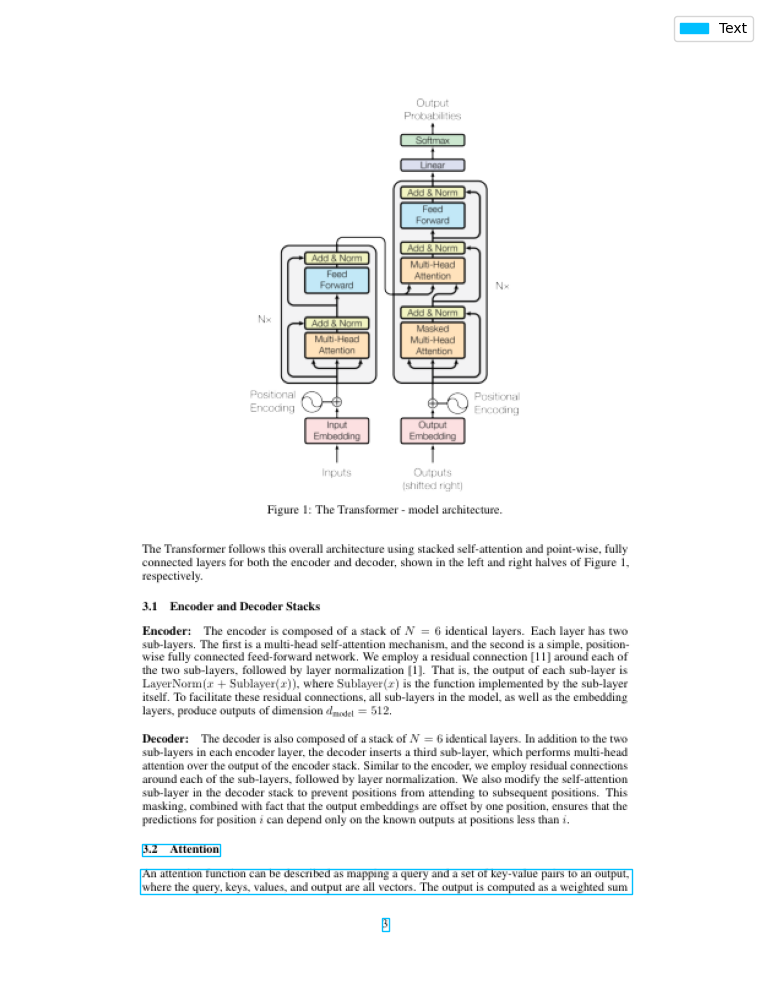

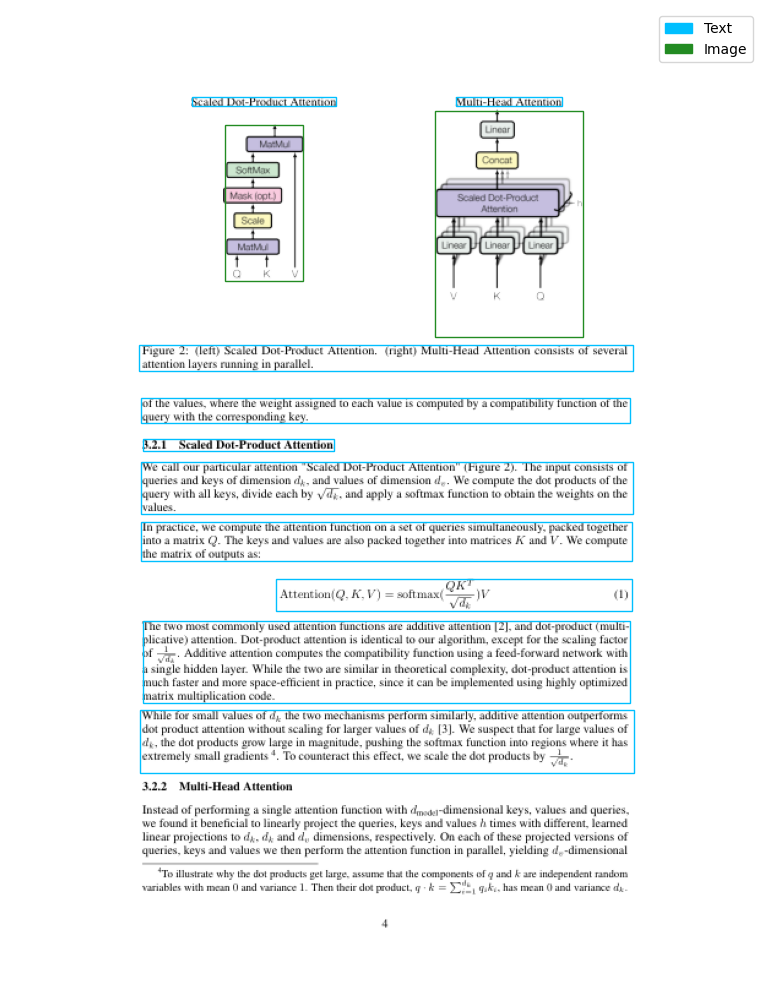

In [38]:
def extract_page_number_from_chunk(chunk):
    elements = chunk.metadata.orig_elements

    page_numbers = set()
    for element in elements:
        page_numbers.add(element.metadata.page_number)

    return page_numbers

def display_chunk_pages(chunk):
    page_numbers = extract_page_number_from_chunk(chunk)
    
    docs = []
    for element in chunk.metadata.orig_elements:
        metadata = element.metadata.to_dict()
        if "Table" in str(type(element)):
            metadata["category"] = "Table"
        elif "Image" in str(type(element)):
            metadata["category"] = "Image"
        else:
            metadata["category"] = "Text"
    
        docs.append(Document(page_content=element.text, metadata=metadata))
    
    for page_number in page_numbers:
        render_page(docs, page_number, False)

display_chunk_pages(chunks[3])

## RAG pipeline

In [39]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [58]:
with get_openai_callback() as cb:
    response = chain.invoke(
        "What is the attention mechanism?"
    )
    print(cb,"\n\n")

print(response)

Tokens Used: 3730
	Prompt Tokens: 3523
		Prompt Tokens Cached: 3328
	Completion Tokens: 207
		Reasoning Tokens: 0
Successful Requests: 1
Total Cost (USD): $0.0004030499999999999 


The attention mechanism is a process that enables a model to focus on specific parts of the input data when producing an output. It maps a query and a set of key-value pairs to an output. The process consists of the following steps:

1. **Matrix Multiplication (MatMul)**: Compute the dot products of the query (Q) with all keys (K).
2. **Scaling**: The dot products are scaled by dividing by the square root of the dimension of the keys (√dk).
3. **Masking (optional)**: This step is applied to prevent attention to certain positions, typically in sequence tasks where future information should not be considered.
4. **Softmax**: Apply the softmax function to the scaled scores to obtain attention weights, which sum to one.
5. **Matrix Multiplication (MatMul)**: Finally, compute the weighted sum of the values (V) us

Tokens Used: 3748
	Prompt Tokens: 3523
		Prompt Tokens Cached: 3328
	Completion Tokens: 225
		Reasoning Tokens: 0
Successful Requests: 1
Total Cost (USD): $0.0004138499999999999
Response: The attention mechanism is a method used to map a query and a set of key-value pairs to an output. The process involves several steps:

1. **Matrix Multiplication (MatMul)**: The queries \(Q\) are multiplied by the keys \(K\) to compute their compatibility. 
2. **Scaling**: The result of the multiplication is scaled by a factor of \(\sqrt{d_k}\) to mitigate the effect of large dot products, which can push the softmax function into regions with very small gradients.
3. **Masking (optional)**: A mask can be applied to prevent certain positions from being attended to, which is particularly important in tasks like sequence generation.
4. **Softmax**: The scaled values are passed through a softmax function, converting them into attention weights.
5. **Final Matrix Multiplication**: The attention weights ar

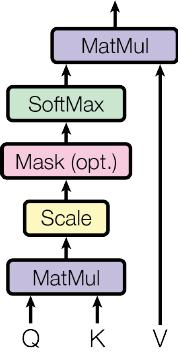

In [62]:
with get_openai_callback() as cb:
    response = chain_with_sources.invoke(
        "What is the attention mechanism?"
    )
    print(cb)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)